# Infer

In [ ]:
!nvidia-smi

Sat Jun  4 10:30:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg/LabelApp/radiology

!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install monailabel-weekly
!pip install monai-weekly
!pip uninstall opencv-contrib-python -y
!pip install opencv-python==4.1.2.30 opencv-contrib-python==4.1.2.30
!pip install pyyaml==5.4.1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CardiacSeg/LabelApp/radiology


In [ ]:
!python main.py --studies '/content/drive/MyDrive/CardiacSeg/SwinUNETR_SegTHOR/infers/crop_foreground'

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
[2022-06-04 10:34:53] [960] [MainThread] [INFO] (monailabel.utils.others.class_utils:36) - Subclass for TaskConfig Found: <class 'lib.configs.deepedit.DeepEdit'>
[2022-06-04 10:34:53] [960] [MainThread] [INFO] (monailabel.utils.others.class_utils:36) - Subclass for TaskConfig Found: <class 'lib.configs.deepgrow_2d.Deepgrow2D'>
[2022-06-04 10:34:53] [960] [MainThread] [INFO] (monailabel.utils.others.class_utils:36) - Subclass for TaskConfig Found: <class 'lib.configs.deepgrow_3d.Deepgrow3D'>
[2022-06-04 10:34:53] [960] [MainThread] [INFO] (monailabel.utils.others.class_utils:36) - Subclass for TaskConfig Found: <class 'lib.configs.seg_cardiac_swin_unetr.SegmentationCardiac'>
[2022-06-04 10:34:53] [960] [MainThread] [INFO] (monailabel.utils.others.class_utils:36) - Subclass for TaskConfig Found: <class 'lib.configs.segmentation.Segmentation'>
[2

## Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg

!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install monailabel-weekly
!pip install monai-weekly
!pip uninstall opencv-contrib-python -y
!pip install opencv-python==4.1.2.30 opencv-contrib-python==4.1.2.30

In [ ]:
import os
from pathlib import PurePath
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from monai.utils import first
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AddChannel,
    SaveImage,
    AsDiscrete,
    AsDiscreted,
    ToNumpyd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    LabelFilterd,
    MapLabelValued,
    SaveImaged,
    ToDeviced,
    EnsureTyped,
    SqueezeDimd
)


from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    TestTimeAugmentation
)

from monai.transforms.utils import allow_missing_keys_mode
from monailabel.transform.post import BoundingBoxd, Restored

import torch
from torch.utils.tensorboard import SummaryWriter

import pandas as pd

## Setup config

In [ ]:
class Config:
  model_repo = 'SwinUNETR_SegTHOR'
  model_name = 'crop_foreground'
  use_pretrained_model = True
  root_dir = './'
  infer_dir = os.path.join(root_dir, model_repo, 'infers', model_name)
  model_dir = os.path.join(root_dir, model_repo, 'models', model_name)
  pretrained_model_pth = os.path.join(model_dir, 'dc_96_best_metric_model.pth')
  img_pth = os.path.join(root_dir, 'dataset/corcta/corcta.nii.gz')
  infer_img_pth = os.path.join(infer_dir, 'corcta/corcta.nii.gz')

config = Config

os.makedirs(config.infer_dir, exist_ok=True)

data_dict = {
  'image': config.img_pth,
}

## Setup pre transforms and post transforms


In [ ]:
pre_transforms = Compose([
    LoadImaged(keys=["image"]),
    AddChanneld(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(
        keys=["image"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear"),
    ),
    ScaleIntensityRanged(
        keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
    ),
    AddChanneld(keys=["image"]),
    ToTensord(keys=["image"]),
])

post_transforms = Compose([
    Orientationd(keys=["pred"], axcodes="LPS"),
    ToNumpyd(keys="pred"),
    Restored(keys=["pred"], ref_image="image"),
    BoundingBoxd(keys="pred", result="result", bbox="bbox")
])

## Check data shape and visualize

img path: ./dataset/corcta/corcta.nii.gz
original img shape: (512, 512, 267)
transformed img shape: torch.Size([1, 1, 129, 129, 68])


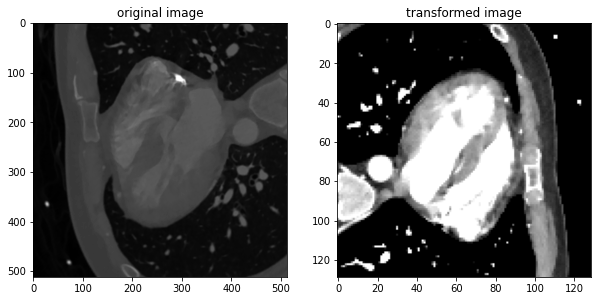

In [ ]:
src_img = LoadImaged(keys=["image"])(data_dict)['image']
trfm_img = pre_transforms(data_dict)['image']
print(f"img path: {data_dict['image']}")
print(f"original img shape: {src_img.shape}")
print(f"transformed img shape: {trfm_img.shape}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].title.set_text("original image")
axes[0].imshow(src_img[:,:,133], cmap='gray')
axes[1].title.set_text("transformed image")
axes[1].imshow(trfm_img[0,0,:,:,30], cmap='gray')

## Create Swin UNETR model

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("cuda is available")
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    print("cuda is not available")
    device = torch.device("cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=2,
    feature_size=48,
    use_checkpoint=True,
).to(device)

cuda is available


In [ ]:
use_pretrained_model = config.use_pretrained_model
pretrained_model_pth = config.pretrained_model_pth
if use_pretrained_model:
  model.load_state_dict(
      torch.load(
          pretrained_model_pth,
          map_location=device
      )
  )
  print(f'load pretrained model: {pretrained_model_pth}')
else:
  print(f'not load pretrained model')

load pretrained model: ./SwinUNETR_SegTHOR/models/crop_foreground/dc_96_best_metric_model.pth


## Infer

In [ ]:
model.eval()
with torch.no_grad():
    data = pre_transforms(data_dict)
    data['pred'] = sliding_window_inference(
        data['image'].to(device), 
        (96, 96, 96),
        4, 
        model,
        overlap=0.8
    )
    data['pred'] = torch.argmax(data['pred'], dim=1)
    data = post_transforms(data)

None of the inputs have requires_grad=True. Gradients will be None


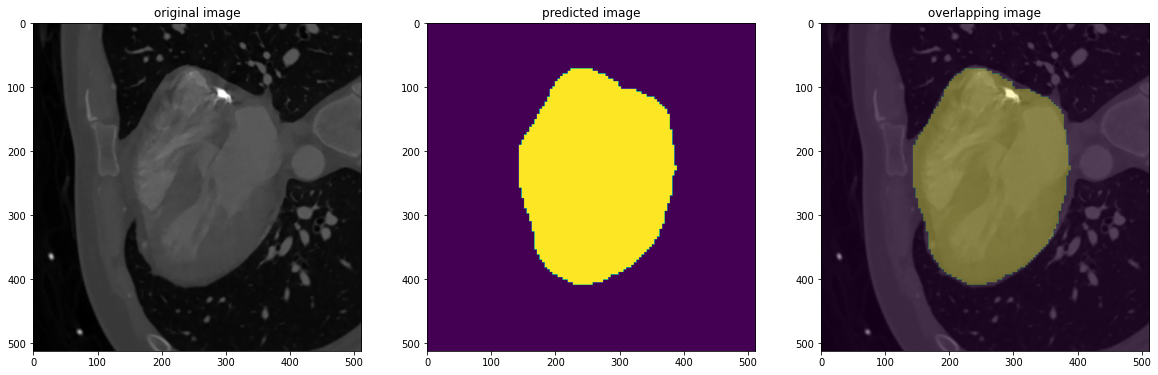

In [ ]:
img = LoadImaged(keys=["image"])(data_dict)['image']
pred = data['pred']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axes = axes.flatten()
axes[0].title.set_text("original image")
axes[0].imshow(img[:,:,133], cmap='gray')
axes[1].title.set_text("predicted image")
axes[1].imshow(pred[:,:,133])
axes[2].title.set_text("overlapping image")
axes[2].imshow(img[:,:,133], cmap='gray')
axes[2].imshow(pred[:,:,133], alpha=0.3)

In [ ]:
img_writer = Compose([
    AddChannel(),
    SaveImage(output_dir=config.infer_dir, output_postfix='')           
])
img_writer(pred)
os.makedirs(os.path.join(config.infer_dir, config.infer_img_pth.split('/')[-2]),exist_ok=True)
!mv {config.infer_dir}/0/0.nii.gz {config.infer_img_pth}
!rm -rf {config.infer_dir}/0

2022-06-04 08:31:04,315 INFO image_writer.py:190 - writing: SwinUNETR_SegTHOR/infers/crop_foreground/0/0.nii.gz
